## Data Acquisition:
For this bounty, I'll be addressing the Product Review Analyzer category. The objective is to scrutinize product reviews, distinguishing the most and least favored products.
The product review dataset was obtained from data.world. Access the dataset [here](https://data.world/crawlfeeds/amazon-uk-shoes-product-reviews-dataset/workspace/file?filename=amazon_uk_shoes_products_dataset_2021_12.csv)

### Step 1: Dataset Loading
I utilize the Pandas library to import and load the CSV file into a Pandas DataFrame.

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'amazon_uk_shoes_products.csv'
data = pd.read_csv(file_path)

## Step 2: Dataset Exploration
I delve into the dataset to comprehend its structure, detect any absent values, and extract meaningful insights from the data.

In [2]:
# Display the first few rows of the dataset
print(data.head())

# Check the data types and non-null counts for each column
print(data.info())

# Check summary statistics for numerical columns
print(data.describe())

# Check for missing values in each column
print(data.isnull().sum())


                                      url  \
0  https://www.amazon.co.uk/dp/B07SBX32T5   
1  https://www.amazon.co.uk/dp/B07SBX32T5   
2  https://www.amazon.co.uk/dp/B07SBX32T5   
3  https://www.amazon.co.uk/dp/B07SBX32T5   
4  https://www.amazon.co.uk/dp/B08SW434MG   

                                        product_name     reviewer_name  \
0  Klasified Women's Transparent Clear Sneaker Sh...  Jocelyn McSayles   
1  Klasified Women's Transparent Clear Sneaker Sh...      Kenia Rivera   
2  Klasified Women's Transparent Clear Sneaker Sh...       Chris Souza   
3  Klasified Women's Transparent Clear Sneaker Sh...   Amazon Customer   
4  GUESS Women's Bradly Gymnastics Shoe, White, 7 UK         Graziella   

         review_title                                        review_text  \
0             Love em  Love these. Was looking for converses and thes...   
1  The plastic ripped  The shoes are very cute, but after the 2nd day...   
2        Good quality                                   

## Step 3: Data Cleaning
Following the gathered insights, I'll proceed with essential data cleansing steps. The null count across most columns is 0, indicating relatively clean data. To streamline sentiment analysis, I'll eliminate redundant columns. Additionally, I'll filter out non-English reviews from the `review_text` column to facilitate smoother analysis.

In [3]:
# List of columns to drop
columns_to_drop = ['url','reviewer_name', 'verified_purchase', 'review_date', 'scraped_at', 'uniq_id']

# Drop the specified columns
data.drop(columns=columns_to_drop, inplace=True)

# Save the modified DataFrame to a new CSV file
new_file_path = 'updated_data.csv'
data.to_csv(new_file_path, index=False)

In [4]:
#filtering out non-english words 
from langdetect import detect

# Function to detect language using langdetect
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'

# Apply language detection to each review comment
data['language'] = data['review_text'].apply(detect_language)

# Filter out non-English reviews
data = data[data['language'] == 'en'] # Keep only English reviews

# Remove the 'language' column as it's not needed
data.drop('language', axis=1, inplace=True)

# Save the filtered DataFrame to a new CSV file
data.to_csv("filtered_english_reviews.csv", index=False)


This code creates a new column 'language' by detecting the language of each review comment. Then, it filters the dataset to keep only the reviews identified as English ('en' in this case) and drops the 'language' column afterward.

## Step 3.1 Data Processing
I'll be processing the `review_text` column, be removing stopwrds, converting all text to lowercase, perfom tokenization, remove punnctuation, and use stemming.

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Download NLTK resources (if not downloaded)
# nltk.download('punkt')
# nltk.download('stopwords')

# Lowercasing
data['review_text'] = data['review_text'].str.lower()

# Tokenization
data['tokens'] = data['review_text'].apply(word_tokenize)

# Removing punctuation
data['tokens'] = data['tokens'].apply(lambda tokens: [word for word in tokens if word not in string.punctuation])

# Removing stopwords
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
data['stemmed'] = data['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# Lemmatization (if preferred)
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# data['lemmatized'] = data['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


## Step 4: Sentiment Analysis
I'll leverage TextBlob to assess the sentiment within the dataset. This approach should reveal the polarity (positive, negative, or neutral) linked to each review, allowing us to aggregate this sentiment data to comprehend the overall sentiment for each product.

In [6]:
from textblob import TextBlob

# Function to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Using polarity to determine sentiment
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis to each review
data['sentiment'] = data['review_text'].apply(analyze_sentiment)

# Aggregate sentiment for each product name
product_sentiment = data.groupby('product_name')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Calculate overall sentiment for each product name
product_sentiment['Overall Sentiment'] = product_sentiment['Positive'] - product_sentiment['Negative']

# Identify the top products based on sentiment
top_products = product_sentiment.sort_values('Overall Sentiment', ascending=False).head(10)


In [7]:
top_products.head()

sentiment,Negative,Neutral,Positive,Overall Sentiment
product_name,,,,
"PUMA - Kids California Casual Shoes, 4 Kids UK, Quarry/Puma White/Puma Team Gold",0.0,0.0,1.0,1.0
"PUMA Men's Respin Sneaker, White White-Limoges Black-high Risk Red, 4 UK",0.0,0.0,1.0,1.0
"PUMA Women's NOVA Sneaker, White/Black, 5 UK",0.0,0.0,1.0,1.0
"PUMA Women's California Sneaker, Black-Metallic, 3 UK",0.0,0.0,1.0,1.0
"PUMA Unisex-Child Wired Sneaker, Black-Black-Black, 2 Little Kid",0.0,0.0,1.0,1.0


This code performs sentiment analysis on the reviews using TextBlob, categorizing each review into positive, negative, or neutral sentiment categories. Then, it aggregates the sentiment for each product, calculating an overall sentiment score for each product based on the difference between positive and negative sentiments.

Finally, it identifies the most popular products based on sentiment by sorting the products based on their overall sentiment scores.

## Step 5: Data Visualization

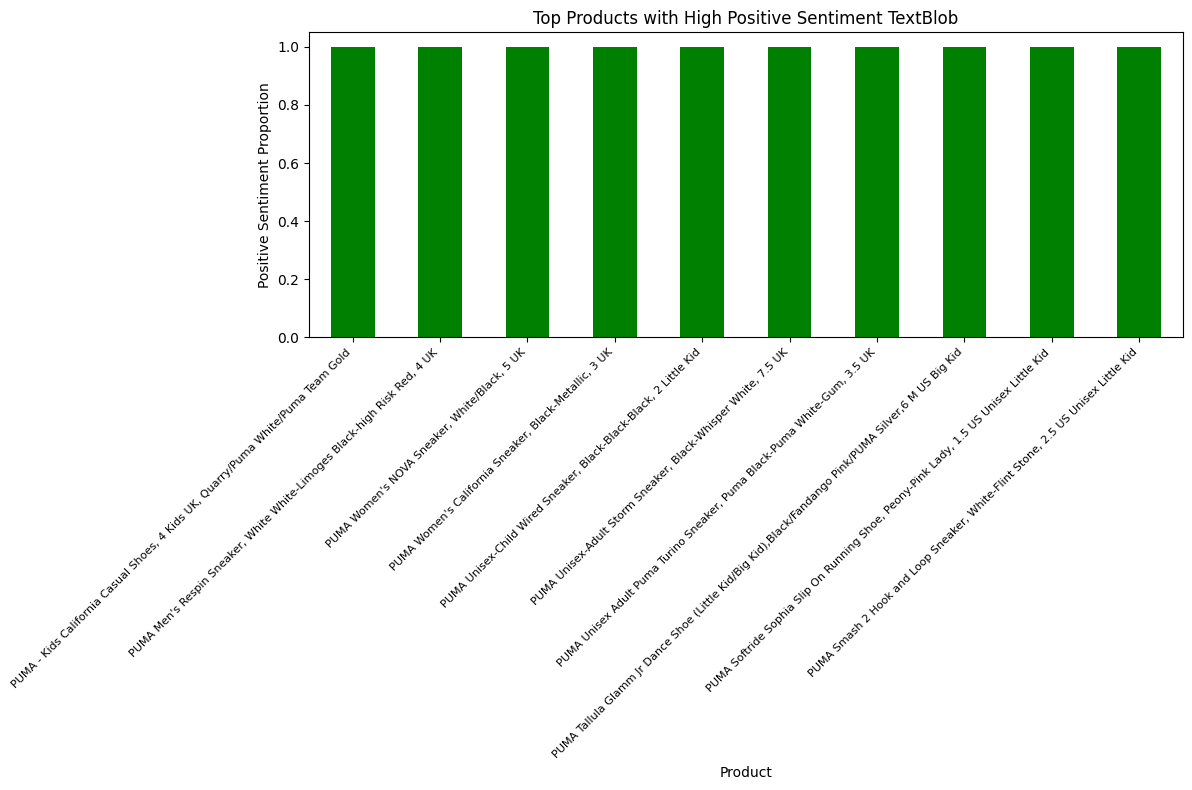

In [8]:
import matplotlib.pyplot as plt

# Sort products by positive sentiment percentage
top_positive_products = product_sentiment['Positive'].sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 8))  # Increase figure size
top_positive_products.plot(kind='bar', color='green')
plt.xlabel('Product')
plt.ylabel('Positive Sentiment Proportion')
plt.title('Top Products with High Positive Sentiment TextBlob')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust label rotation and size
plt.tight_layout()
plt.show()


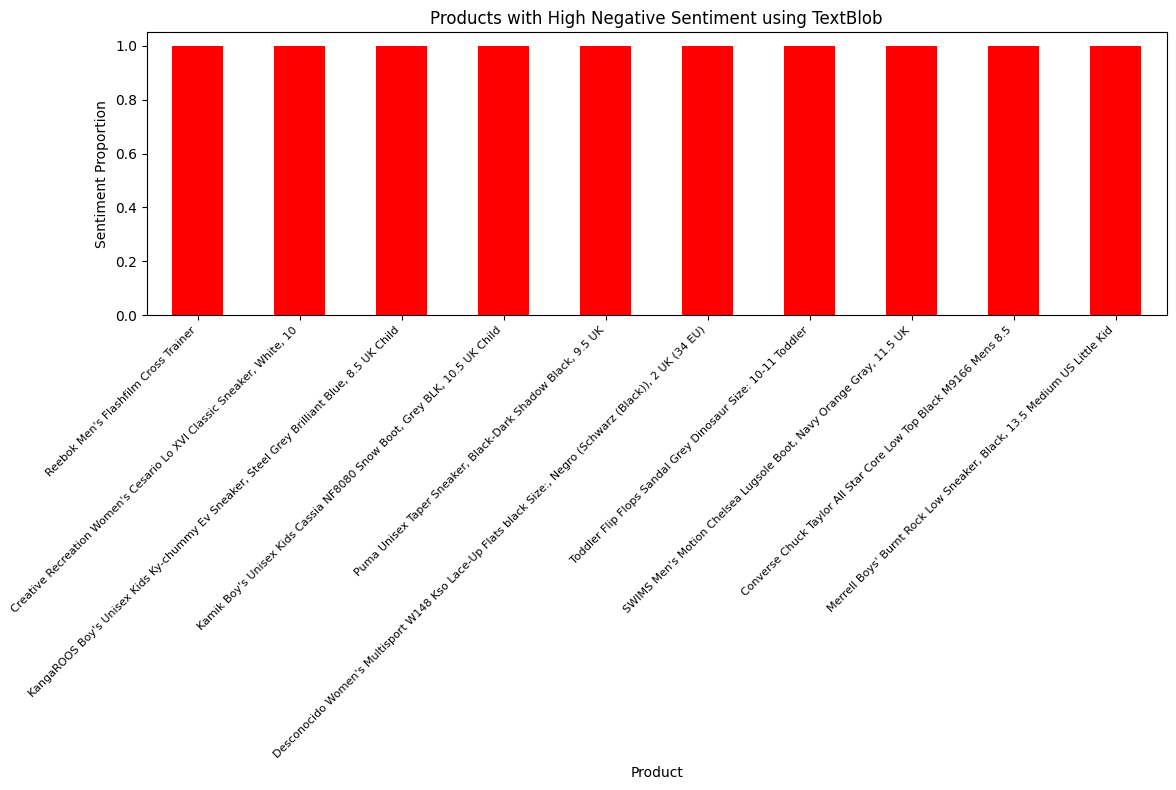

In [9]:
import matplotlib.pyplot as plt

# Filter sentiment data for products with high negative sentiment using TextBlob
high_negative_textblob = product_sentiment.sort_values('Negative', ascending=False).head(10)

# Plotting sentiment for products with high negative sentiment using TextBlob
colors = ['grey' if col != 'Negative' else 'red' for col in high_negative_textblob.columns]
high_negative_textblob.drop('Overall Sentiment', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.xlabel('Product')
plt.ylabel('Sentiment Proportion')
plt.title('Products with High Negative Sentiment using TextBlob')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend().remove()
plt.tight_layout()
plt.show()



## Vader Sentiment Analysis
I aim to derive distinct sentiment analysis outcomes using both TextBlob and VADER for comparison or merged insights.

In [10]:
import nltk
#nltk.download('vader_lexicon')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to perform sentiment analysis using VADER
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)
    
    # Classify the sentiment based on compound score
    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER sentiment analysis to each review
data['sentiment_vader'] = data['review_text'].apply(analyze_sentiment_vader)

# Aggregate sentiment for each product name using VADER
product_sentiment_vader = data.groupby('product_name')['sentiment_vader'].value_counts(normalize=True).unstack().fillna(0)

# Calculate overall sentiment for each product name using VADER
product_sentiment_vader['Overall Sentiment'] = product_sentiment_vader['Positive'] - product_sentiment_vader['Negative']

# Identify the top products based on VADER sentiment
top_products_vader = product_sentiment_vader.sort_values('Overall Sentiment', ascending=False).head(10)


This code snippet incorporates VADER sentiment analysis. It calculates sentiment scores using VADER's compound score and then categorizes the sentiment as positive, negative, or neutral based on the threshold values for the compound score. Adjust the threshold values according to your preference for classifying sentiments.

In [11]:
top_products_vader.head()

sentiment_vader,Negative,Neutral,Positive,Overall Sentiment
product_name,,,,
"PUMA - Kids California Casual Shoes, 4 Kids UK, Quarry/Puma White/Puma Team Gold",0.0,0.0,1.0,1.0
"PUMA Pacer Future Sneaker, Black White, 6.5 US Unisex Big Kid",0.0,0.0,1.0,1.0
"PUMA Unisex-Child Wired Sneaker, Black-Black-Black, 2 Little Kid",0.0,0.0,1.0,1.0
"PUMA Unisex-Adult Popcat Slide Sandal, Black/White, 11 UK",0.0,0.0,1.0,1.0
"PUMA Unisex Cool Cat Slide Sandal, Black White-High Risk Red, 5 M US Big Kid",0.0,0.0,1.0,1.0


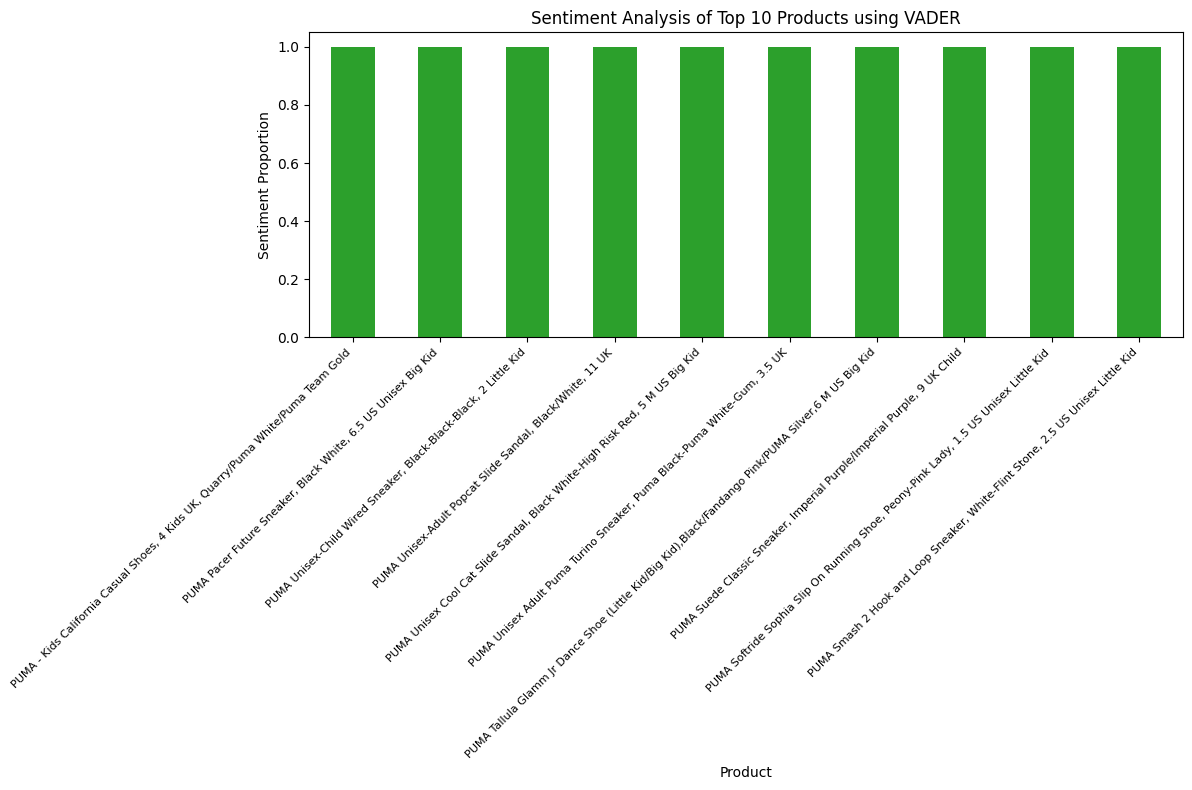

In [12]:
import matplotlib.pyplot as plt

# Plotting sentiment for the top products using VADER
top_products_vader.iloc[:10].drop('Overall Sentiment', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Product')
plt.ylabel('Sentiment Proportion')
plt.title('Sentiment Analysis of Top 10 Products using VADER')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend().remove()
plt.tight_layout()
plt.show()


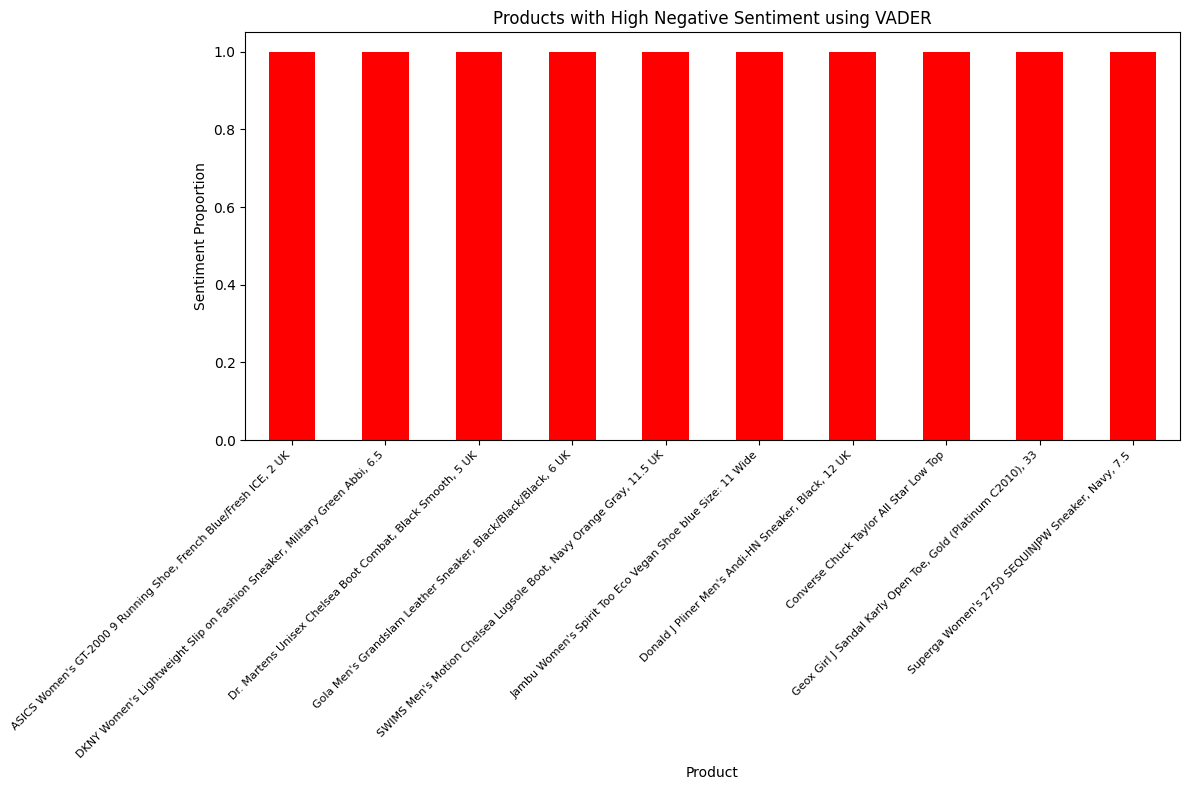

In [13]:
import matplotlib.pyplot as plt

# Filter sentiment data for products with high negative sentiment using VADER
high_negative_vader = product_sentiment_vader.sort_values('Negative', ascending=False).head(10)

# Plotting sentiment for products with high negative sentiment using VADER
colors = ['grey' if col != 'Negative' else 'red' for col in high_negative_vader.columns]
high_negative_vader.drop('Overall Sentiment', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.xlabel('Product')
plt.ylabel('Sentiment Proportion')
plt.title('Products with High Negative Sentiment using VADER')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend().remove()
plt.tight_layout()
plt.show()


It appears that TextBlob and Vader exhibit comparable outcomes for positively reviewed products but diverge in their assessments for products with negative reviews. I aim to further investigate and scrutinize the nuances between both analyses to gain a more comprehensive understanding.

## Comparing nuances between TextBlob and Vader results

In [14]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to compare TextBlob and VADER sentiment analyses
def compare_sentiments(text):
    blob = TextBlob(text)
    vader = SentimentIntensityAnalyzer()
    textblob_score = blob.sentiment.polarity
    vader_score = vader.polarity_scores(text)['compound']
    return textblob_score, vader_score

# Apply comparison function to your dataset
data[['textblob_score', 'vader_score']] = data['review_text'].apply(lambda x: pd.Series(compare_sentiments(x)))


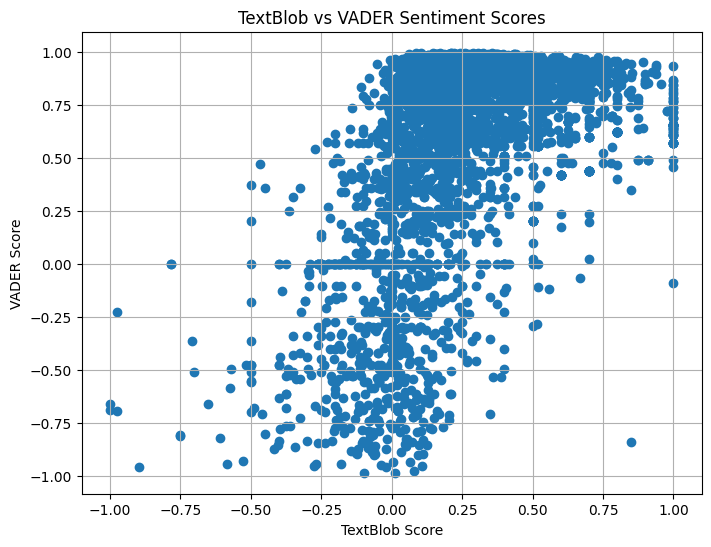

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(data['textblob_score'], data['vader_score'])
plt.xlabel('TextBlob Score')
plt.ylabel('VADER Score')
plt.title('TextBlob vs VADER Sentiment Scores')
plt.grid(True)
plt.show()


The scatterplot reveals that both TextBlob and VADER tend to cluster data points on the positive side of the axis.

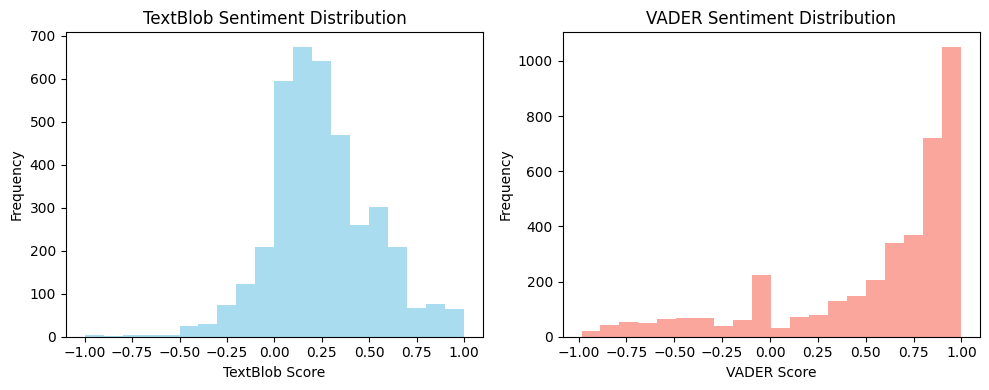

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data['textblob_score'], bins=20, color='skyblue', alpha=0.7)
plt.xlabel('TextBlob Score')
plt.ylabel('Frequency')
plt.title('TextBlob Sentiment Distribution')

plt.subplot(1, 2, 2)
plt.hist(data['vader_score'], bins=20, color='salmon', alpha=0.7)
plt.xlabel('VADER Score')
plt.ylabel('Frequency')
plt.title('VADER Sentiment Distribution')

plt.tight_layout()
plt.show()


While both tools capture sentiment trends, the histograms unveil distinct patterns. TextBlob's distribution reveals a preference for neutral language, whereas Vader tends to skew towards positive interpretations.

### Delving deeper: Uncovering the interplay between reviewer ratings and sentiment: 
This integration aims to identify potential discrepancies or convergences between explicit ratings and the underlying sentiment expressed in the text.

In [17]:
# Map sentiment to numeric values for TextBlob
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
data['sentiment_value'] = data['sentiment'].map(sentiment_map)

# Analyze the relationship between review_rating and sentiment_value
correlation = data['review_rating'].corr(data['sentiment_value'])
print(f"Correlation between review_rating and sentiment_value: {correlation}")


Correlation between review_rating and sentiment_value: 0.41315691718576397


This code converts the textual sentiment labels ('Positive', 'Neutral', 'Negative') into numeric values and then calculates the correlation between the reviewer's rating (review_rating) and the derived sentiment value (sentiment_value).

The correlation coefficient value between review_rating and sentiment_value (which represents the numeric value assigned to sentiment) is approximately 0.413. This means that there is some degree of positive relationship between the two variables: as the review_rating tends to increase, the sentiment_value tends to increase as well, indicating that higher ratings tend to align with more positive sentiments identified from the text analysis.

## Project Explanation
In embarking on this project, I outlined a clear strategy. Initially, I aimed to gather data through web scraping or utilizing pre-existing datasets. Given the complexities of web scraping, I opted for the latter, sourcing a product review dataset from `data.world` after an extensive search. The dataset, available [here](https://data.world/crawlfeeds/amazon-uk-shoes-product-reviews-dataset/workspace/file?filename=amazon_uk_shoes_products_dataset_2021_12.csv), laid the foundation for my analysis.

Upon diving into data processing, the dataset appeared mostly clean, except for non-English reviews, posing a challenge. Considering the multitude of languages, I pivoted to filter out English reviews from the mix, streamlining the process. Post this, I delved into data preparation, employing techniques like tokenization, lowercase normalization, and stemming.

Moving to sentiment analysis, I employed both TextBlob and VADER, discovering intriguingly congruent outcomes for products with positive sentiments. However, the top products marked by negative sentiments negative sentiments varied. Diving deeper into the nuances, I observed TextBlob's sentiment tending towards neutrality while VADER skewed towards positivity.

In a bid to broaden the analysis, I merged the `review_rating` column with sentiment values, revealing an approximate correlation coefficient of 0.413. This correlation hints at a mild yet discernible positive relationship between the reviewer's ratings and the sentiment analysis results.

In conclusion, this project successfully delved into the realm of sentiment analysis, utilizing a robust dataset of Amazon UK shoe product reviews. Key findings include:

- Congruent outcomes for positive sentiments: Both TextBlob and VADER libraries identified similar products with predominantly positive sentiments, suggesting a degree of consistency in sentiment detection.
- Divergence in negative sentiment identification: The libraries diverged in their identification of products with the most negative sentiments, highlighting potential differences in their sensitivity to negative language.
- TextBlob's neutrality and VADER's positivity: TextBlob's sentiment scores leaned towards neutrality, while VADER's scores exhibited a more positive bias, suggesting the importance of understanding library-specific tendencies.
-  Correlation between ratings and sentiment: A moderate correlation of 0.413 emerged between reviewer ratings and sentiment analysis results, indicating a positive relationship but also suggesting that sentiment scores capture aspects beyond numerical ratings.